# Symbol Detection

dataset: https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols

sample model: https://github.com/OdyAsh/Handwritten-M2L/blob/main/model.ipynb

In [1]:
import os
import random 

import cv2
import pickle
import numpy as np
from functools import cmp_to_key

from keras.src.layers import BatchNormalization
from keras.src.ops import shape
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras import ops   
import matplotlib.pyplot as plt

In [2]:
#converts file names to latex
dic = {
    "-": r"-",
    "(": r"(",
    ")": r")",
    "+": r"+",
    "=": r"=",
    "times": r"\times",
    "0": r"0",
    "1": r"1",
    "2": r"2",
    "3": r"3",
    "4": r"4",
    "5": r"5",
    "6": r"6",
    "7": r"7",
    "8": r"8",
    "9": r"9",
    "div": r"\div", 
    "y": r"y", 
    "X": r"x", 
    "C": r"c", 
    "M": r"m"
}




In [3]:
# set class size
class_size = 2000

# loads and splits data into imgs and labels 
# inputs: Data - directory where all the class folders are stored
#         Dic - dictionary of all the classes that are to be classified 
#
# outputs: imgs - 

def loadData(DataDir, class_size, class_dic):
  imgs = []
  labels = []
  
  # iterate through each symbol and extract all files 
  for k, v in class_dic.items():
    path = os.path.join(DataDir, k)
    c=0 
    for imgName in os.listdir(path):
      try:
        img = cv2.imread(os.path.join(path, imgName), cv2.COLOR_BGR2GRAY)       
        imgs.append(img)
        labels.append(v)
        
        # stop adding when desired class size is reached
        c+=1
        if c>=class_size:
            break

      except Exception as e:
        print(e)

  return imgs, labels


imgs, labels = loadData(r"input\extracted_images", 1000, dic)



In [4]:

# serialise for faster opening 
with open("x_symbols.pickle", 'wb') as f:
   pickle.dump(imgs, f)
with open("y_latex.pickle", 'wb') as f:
   pickle.dump(labels, f)

In [5]:

# Open the file in binary read mode
with open('x_symbols.pickle', 'rb') as file:
    # Deserialize the dataset object from the file
    imgs = pickle.load(file)
with open('y_latex.pickle', 'rb') as file:
    labels = pickle.load(file)

In [6]:
# create dictionary to encode symbol name as numbers
dic_list = [v for k, v in dic.items()]
latexToNums = {k: v for v, k in enumerate(dic_list)}
numsToLatex = {v: k for v, k in enumerate(dic_list)}

print(latexToNums)
print(latexToNums)
print(len(dic), len(latexToNums))
print(np.unique(labels))

{'-': 0, '(': 1, ')': 2, '+': 3, '=': 4, '\\times': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '\\div': 16, 'y': 17, 'x': 18, 'c': 19, 'm': 20}
{'-': 0, '(': 1, ')': 2, '+': 3, '=': 4, '\\times': 5, '0': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '9': 15, '\\div': 16, 'y': 17, 'x': 18, 'c': 19, 'm': 20}
21 21
['(' ')' '+' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' '\\div'
 '\\times' 'c' 'm' 'x' 'y']


In [7]:

# defining augmentation function
def augment_erode_iterations(image, label, kernel_size):
  img = image

  # eroding image to add line tickness
  kernel = np.ones((kernel_size, kernel_size), np.uint8)
  img = cv2.erode(img, kernel)

  return img, label 



In [8]:
# defining input shape and number of classes
input_shape = (45, 45, 1) 
num_classes = 21

# imgs and labels 
imgs_augmented = []
labels_augmented = []

# iterating through all images in the dataset
for i in range(len(imgs)):
    # two types of line thickness
    img_erode_1, label_1 = augment_erode_iterations(imgs[i], labels[i], 3)


    # appending to augmented dataset
    imgs_augmented.append(imgs[i])
    imgs_augmented.append(img_erode_1)

    
    # labels are the same for different augmentations 
    labels_augmented.append(labels[i])
    labels_augmented.append(label_1)

# splitting data in training and testing data
x_train, x_test, y_train, y_test = train_test_split(imgs_augmented, labels_augmented, test_size=0.33, stratify=labels_augmented, random_state=42)


# Convert data into np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


# converting latex representation to numerical representation
y_train_nums = [latexToNums[item] for item in y_train]
y_test_nums = [latexToNums[item] for item in y_test]

# convert class vectors to binary class matrices
y_train_nums = [latexToNums[item] for item in y_train]
y_test_nums = [latexToNums[item] for item in y_test]

y_train_cat = keras.utils.to_categorical(y_train_nums, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_nums, num_classes)


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("y_test shape:", y_test_cat.shape)



x_train shape: (27963, 45, 45, 1)
x_test shape: (13773, 45, 45, 1)
y_train_cat shape: (27963, 21)
y_test shape: (13773, 21)


In [9]:
model = keras.Sequential(
    
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21)             │       108,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,701 (498.83 KB)

 Trainable params: 127,701 (498.83 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 128
epochs =20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

print(history.history.keys())

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5371 - loss: 1.6796 - val_accuracy: 0.8513 - val_loss: 0.5514
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8584 - loss: 0.4719 - val_accuracy: 0.9035 - val_loss: 0.3167
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9094 - loss: 0.2994 - val_accuracy: 0.9213 - val_loss: 0.2500
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9302 - loss: 0.2318 - val_accuracy: 0.9399 - val_loss: 0.1969
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9364 - loss: 0.2020 - val_accuracy: 0.9467 - val_loss: 0.1668
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9468 - loss: 0.1674 - val_accuracy: 0.9510 - val_loss: 0.1593
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9515 - loss: 0.1490 - val_accuracy: 0.9571 - val_loss: 0.1380
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9576 - loss: 0.1318 - val_accu

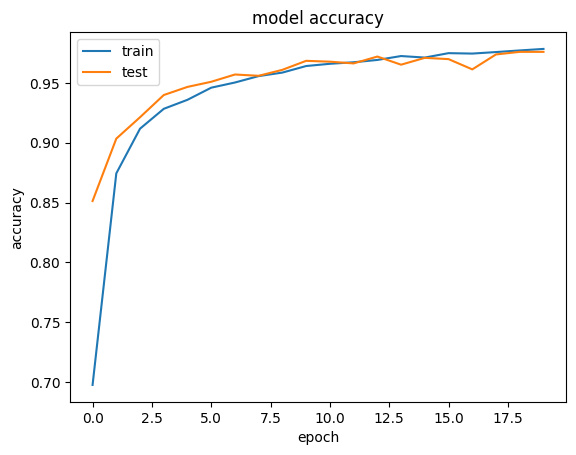

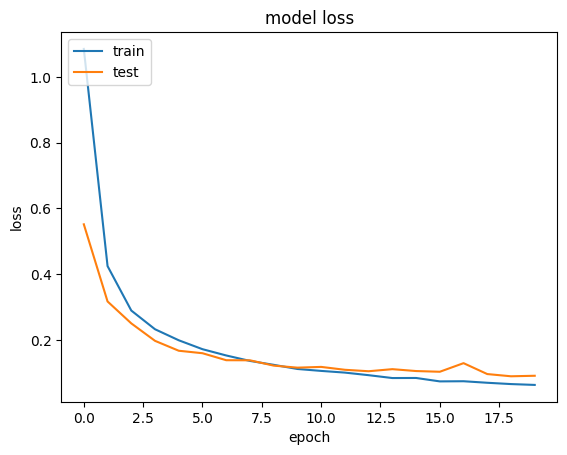

In [12]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


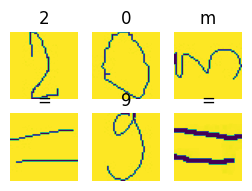

In [13]:
import math 
n = 6
s = math.ceil(math.sqrt(n))
# score = model.evaluate(x_test, y_test_cat, verbose=0)
# print("Test loss:", score[0])
# print("Test accuracy:", score[1])

#testing match between data and labels

plt.figure(figsize=(s, s))


for i in range(n):
    ax = plt.subplot(s, s, i + 1)
    j = i+ 300
    
    y_pred = model.predict(tf.expand_dims(x_test[j], axis=0))
    plt.imshow(x_test[j])
    plt.title(numsToLatex[y_pred.argmax(axis=-1)[0]])
    plt.axis('off')




In [19]:
model.save(r'models\test_set_1_classification_augmented.keras')